<figure style="text-align: center;">
  <img src="_static/intro/title_page.png" style="display: block; margin: 0 auto; width: 100%;">
</figure>

### Variogram Models, Simulation Examples

Michael J. Pyrcz, Professor, The University of Texas at Austin 

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Chapter of e-book "Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy". 

```{admonition} Cite this e-Book as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy, https://geostatsguy.github.io/GeostatsPyDemos_Book.  
```

The workflows in this book and more are available here:

```{admonition} Cite the GeostatsPyDemos GitHub Repository as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, GeostatsPyDemos: GeostatsPy Python Package for Spatial Data Analytics and Geostatistics Demonstration Workflows Repository (0.0.1). Zenodo. https://zenodo.org/doi/10.5281/zenodo.12667035

[![DOI](https://zenodo.org/badge/777871341.svg)](https://zenodo.org/doi/10.5281/zenodo.12667035)

```

By Michael J. Pyrcz <br />
&copy; Copyright 2024.

This chapter is a tutorial for / demonstration of  **Visualizing Variogram Models in 1D Simulation** with GeostatsPy.

**YouTube Lecture**: check out my lectures on:

* [Variogram Modeling](https://youtu.be/-Bi63Y3u6TU?si=-kwvFLicNTbg85xL)
* [Stochastic Simulation](https://youtu.be/3cLqK3lR56Y?si=3WhHX5QOZrrtlgAI). For your convenience here's a summary of salient points.

#### Variogram Modeling

Spatial continuity can be modeled with nested, positive definite variogram structures:

$$
\Gamma_x(\bf{h}) = \sum_{i=1}^{nst} \gamma_i(\bf{h})
$$

where $\Gamma_x(\bf{h})$ is the nested variogram model resulting from the summation of $nst$ nested variograms  $\gamma_i(\bf{h})$.

The types of structure commonly applied include:

* spherical
* exponential
* Gaussian
* nugget

Other less common models include:

* hole effect
* dampened hole effect
* power law

these will not be covered here.

Each one of these variogram structures, $\gamma_i(\bf{h})$, is based on a geometric anisotropy model parameterized by the orientation and range in the major and minor directions.  In 2D this is simply an azimuth and ranges, $azi$, $a_{maj}$ and $a_{min}$. Note, the range in the minor direction (orthogonal to the major direction).

The geometric anisotropy model assumes that the range in all off-diagonal directions is based on an ellipse with the major and minor axes aligned with and set to the major and minor for the variogram.

$$
\bf{h}_i = \sqrt{\left(\frac{r_{maj}}{a_{maj_i}}\right)^2 + \left(\frac{r_{maj}}{a_{maj_i}}\right)^2}  
$$

Therefore, if we know the major direction, range in major and minor directions, we may completely describe each nested component of the complete spatial continuity of the variable of interest, $i = 1,\dots,nst$.

Some comments on modeling nested variograms:

* we can capture nugget, short and long range continuity structures

* we rely on the geometric anisotropy model, so all structures must inform the same level of contribution (proportion of the sill) in all directions.

* the geometric anisotropy model is based on azimuth of the major direction of continuity, range in the major direction and range in the minor direction (orthogonal to the major direction).  The range is interpolated between the major and minor azimuths with a ellipse model

* we can vary the type of variogram, direction or azimuth of the major direction, and major and minor ranges by structure

#### Sequential Gaussian Simulation

With sequential Gaussian simulation we build on kriging by:

* adding a random residual with the missing variance

* sequentially adding the simulated values as data to correct the covariance between the simulated values

The resulting model corrects the issues of kriging, as we now:

* reproduce the global feature PDF / CDF

* reproduce the global variogram

* while providing a model of uncertainty through multiple realizations

To help calibrate your eye, I provide examples of 1D simulated realizations with their associated variogram models. 

#### Load the Required Libraries

The following code loads the required libraries.

In [3]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilities, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python      
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__)) 

GeostatsPy version: 0.0.71


We will also need some standard packages. These should have been installed with Anaconda 3.

In [5]:
import os                                                     # set working directory, run executables

from tqdm import tqdm                                         # suppress the status bar
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrays for gridded data
import pandas as pd                                           # DataFrames for tabular data
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib import gridspec                               # customized subplots
from scipy import stats                                       # summary statistics
import math                                                   # trig etc.
import scipy.signal as signal                                 # kernel for moving window calculation
import random
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
cmap = plt.cm.inferno                                         # color map
from IPython.utils import io                                  # mute simulation outputs

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare Functions

This is a convenience function to add major and minor gridlines to our plots.

In [7]:
def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks 

#### Make a Simple Dataset

We build a reference distribution, data outside the model to control the distribution only. 

* Then we add 3 points along a 1D section.

In [9]:
df = pd.DataFrame(np.vstack([np.full(1000,-9999),np.random.normal(size=1000),
                np.random.normal(loc=1000,scale=200,size=1000)]).T, columns= ['X','Y','Lithium'])
df.loc[0,'X'] = 105; df.loc[0,'Y'] = 5.0; df.loc[0,'Lithium'] = 800
df.loc[1,'X'] = 505; df.loc[1,'Y'] = 5.0; df.loc[1,'Lithium'] = 1000
df.loc[2,'X'] = 905; df.loc[2,'Y'] = 5.0; df.loc[2,'Lithium'] = 1300
df.head()

,X,Y,Lithium
0,105.0,5.000000,800.000000
1,505.0,5.000000,1000.000000
2,905.0,5.000000,1300.000000
3,-9999.0,-1.362301,1111.194663
4,-9999.0,0.627225,651.173336


#### Set Limits for Plotting, Colorbars and Map Specification

Limits are applied for data and model visualization. Grid specification is for the 1D simulations (note, ny = 1 for 1D).

In [11]:
nx = 100; xmn = 5.0; xsiz = 10.0                              # grid parameters
ny = 1; ymn = 5.0; ysiz = 10.0

xmin = xmn - 0.5 * xsiz
xmax = xmin + nx * xsiz

ndmin = 0; ndmax = 20; radius = 2000; skmean = 0; nreal = 10 

lithmin = 0.0; lithmax = 2000.0                               # feature limits

tmin = -9999.9; tmax = 9999.9                                 # triming limits

nxdis = 1; nydis = 1                                          # number of discretizations for block kriging, not tested

#### Spherical Variogram Model

A very commonly observed variogram / spatial continuity form in many settings

* Piecewise, beyond the range is equal to the sill

The equation:

$$
\gamma(\bf{h} ) = c_1 \cdot \text{Sph} \left( \frac{\bf{h} }{a} \right) =
\left\{ 
  \begin{array}{ c l }
    c_1 \cdot \left[ 1.5 \left( \frac{\bf{h} }{a} \right) -  0.5 \left( \frac{\bf{h} }{a} \right)^3 \right] & h < a \\
    c_1 & h \ge a
  \end{array}
\right.
$$

where $𝑐_1$ is the contribution, $𝑎$ is the range and $\bf{𝐡}$ is the lag distance

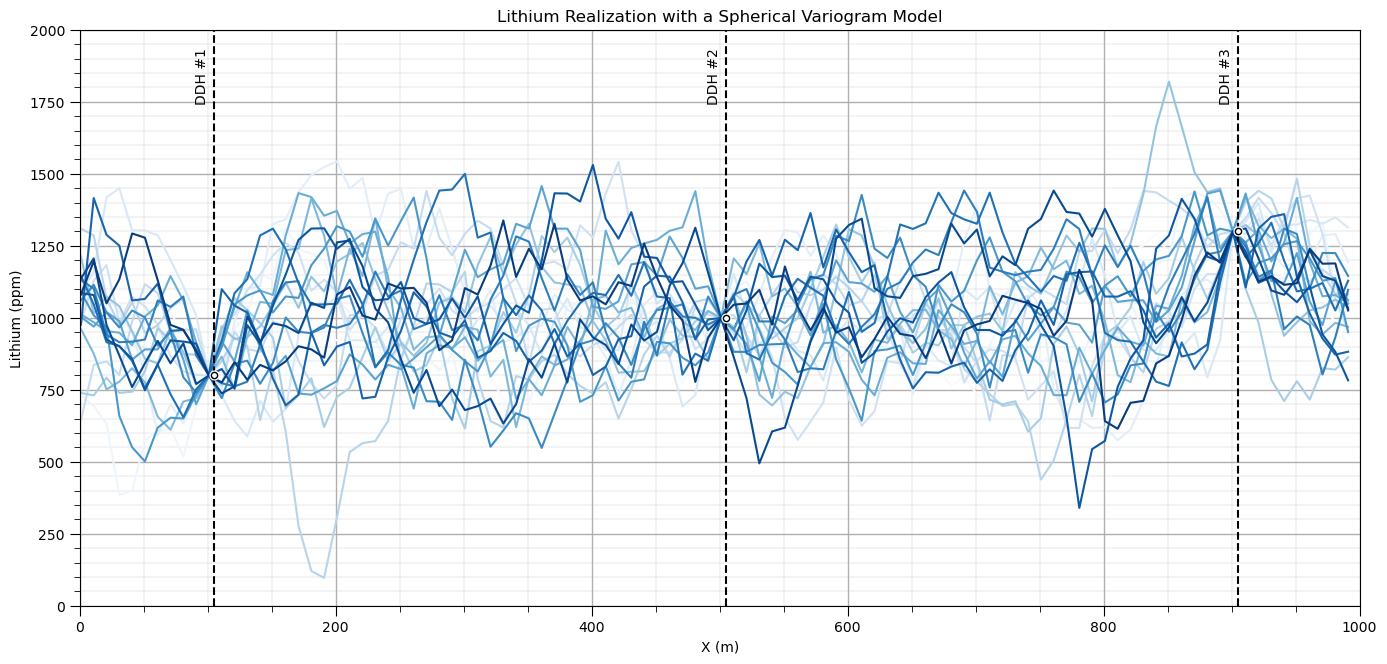

In [13]:
nreal = 20; vrange = 100                                      # number of realizations and variogram range

vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=90.0,hmaj1=vrange,hmin1=5)

with io.capture_output() as captured:                         # simulation while muting output
    sim_spherical = geostats.sgsim(df,'X','Y','Lithium',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,
        dftrans=0,tcol=0,twtcol=0,zmin=0.0,zmax=2000.0,ltail=1,ltpar=0.0,utail=1,utpar=2000,nsim=nreal,
        nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73074,ndmin=ndmin,ndmax=ndmax,nodmax=10,
        mults=0,nmult=2,noct=-1,ktype=0,colocorr=0.0,sec_map=0,vario=vario).reshape((20,100))

plt.subplot(111)                                              # plot variograms
for i in range(0, nreal):    
    plt.plot(np.arange(1,(nx*xsiz),xsiz),sim_spherical[i],color=plt.cm.Blues(i/nreal),label='Real ' + str(i+1),zorder=1)
        
for idata in range(0,3):                                      # plot data
    plt.plot([df.loc[idata,'X'],df.loc[idata,'X']],[lithmin,lithmax],color='black',ls='--')
    plt.scatter(df.loc[idata,'X'],df.loc[idata,'Lithium'],s=20,color='white',edgecolor='black',zorder=10)
    plt.scatter(df.loc[idata,'X'],df.loc[idata,'Lithium'],s=40,color='white',edgecolor='white',zorder=9)
    plt.annotate(r'DDH #' + str(idata+1),(df.loc[idata,'X']-15,1750),rotation = 90);
    
plt.ylim([lithmin,lithmax]); plt.xlim([xmin,xmax]); add_grid()
plt.xlabel('X (m)'); plt.ylabel('Lithium (ppm)'); plt.title('Lithium Realization with a Spherical Variogram Model')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

#### Exponential Variogram Model

Also very commonly observed variogram / spatial continuity form

* Less short-scale continuity than spherical, and reaches sill asymptotically, range is at 95% of the sill 

The equation:

$$
\gamma( \bf{h} ) = c_1 \cdot \text{ Exp } \left( \frac{ \bf{h} }{𝑎} \right) = c_1 \cdot \left[ 1.0 − \text{exp} \left(−3 \cdot \left( \frac{ \bf{h} }{𝑎} \right) \right) \right]
$$

where $𝑐_1$ is the contribution, $𝑎$ is the range and $\bf{h}$ is the lag distance.

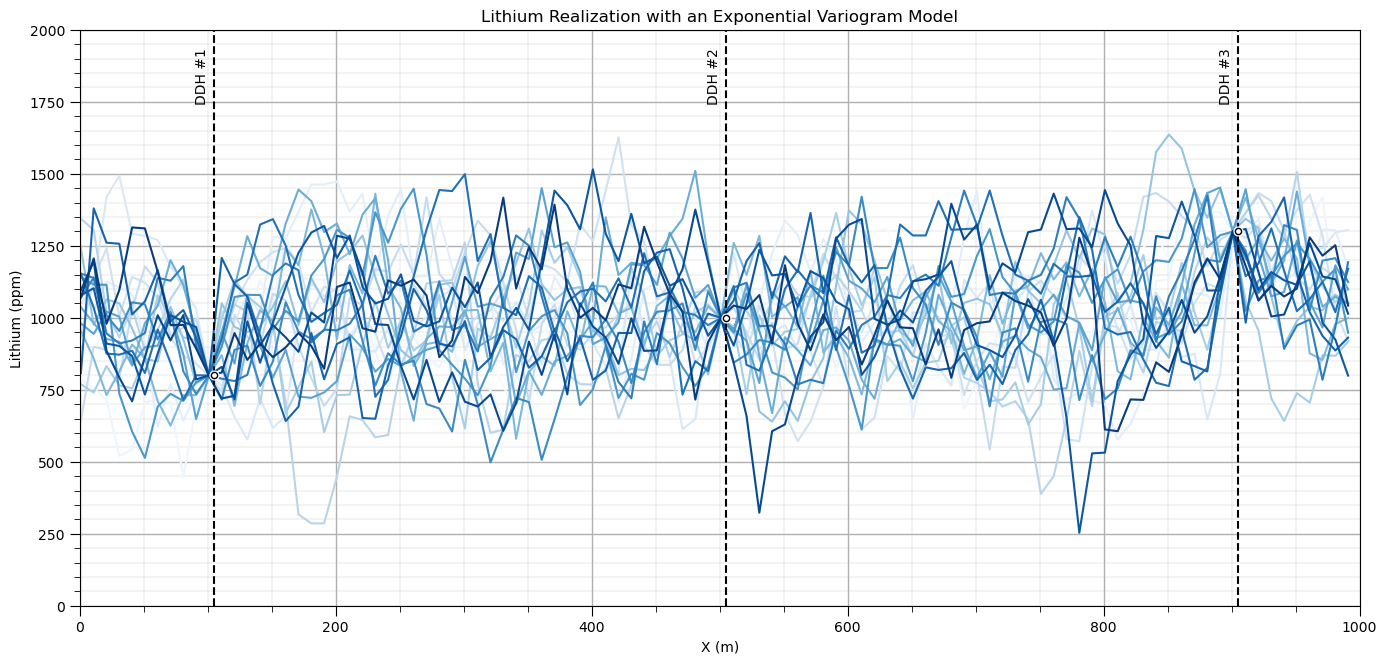

In [15]:
nreal = 20; vrange = 100                                      # number of realizations and variogram range

vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=2,cc1=1.0,azi1=90.0,hmaj1=vrange,hmin1=5)

with io.capture_output() as captured:                         # simulation while muting output
    sim_exponential = geostats.sgsim(df,'X','Y','Lithium',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,
        dftrans=0,tcol=0,twtcol=0,zmin=0.0,zmax=2000.0,ltail=1,ltpar=0.0,utail=1,utpar=2000,nsim=nreal,
        nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73074,ndmin=ndmin,ndmax=ndmax,nodmax=10,
        mults=0,nmult=2,noct=-1,ktype=0,colocorr=0.0,sec_map=0,vario=vario).reshape((20,100))

plt.subplot(111)                                              # plot variograms
for i in range(0, nreal):    
    plt.plot(np.arange(1,(nx*xsiz),xsiz),sim_exponential[i],color=plt.cm.Blues(i/nreal),label='Real ' + str(i+1),zorder=1)
        
for idata in range(0,3):                                      # plot data
    plt.plot([df.loc[idata,'X'],df.loc[idata,'X']],[lithmin,lithmax],color='black',ls='--')
    plt.scatter(df.loc[idata,'X'],df.loc[idata,'Lithium'],s=20,color='white',edgecolor='black',zorder=10)
    plt.scatter(df.loc[idata,'X'],df.loc[idata,'Lithium'],s=40,color='white',edgecolor='white',zorder=9)
    plt.annotate(r'DDH #' + str(idata+1),(df.loc[idata,'X']-15,1750),rotation = 90);
    
plt.ylim([lithmin,lithmax]); plt.xlim([xmin,xmax]); add_grid()
plt.xlabel('X (m)'); plt.ylabel('Lithium (ppm)'); plt.title('Lithium Realization with an Exponential Variogram Model')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

#### Gaussian Variogram Model

Less commonly observed variogram / spatial continuity form, e.g., for thickness and elevation

* Much more short-scale continuity than spherical, and reaches sill asymptotically, range is at 95% of the sill 

The equation:

$$
\gamma( \bf{h} ) = c_1 \cdot \text{ Gaus } \left( \frac{ \bf{h} }{𝑎} \right) = c_1 \cdot \left[ 1.0 − \text{exp} \left(−3 \cdot \left( \frac{ \bf{h} }{𝑎} \right)^2 \right) \right]
$$

where $𝑐_1$ is the contribution, $𝑎$ is the range and $\bf{h}$ is the lag distance.

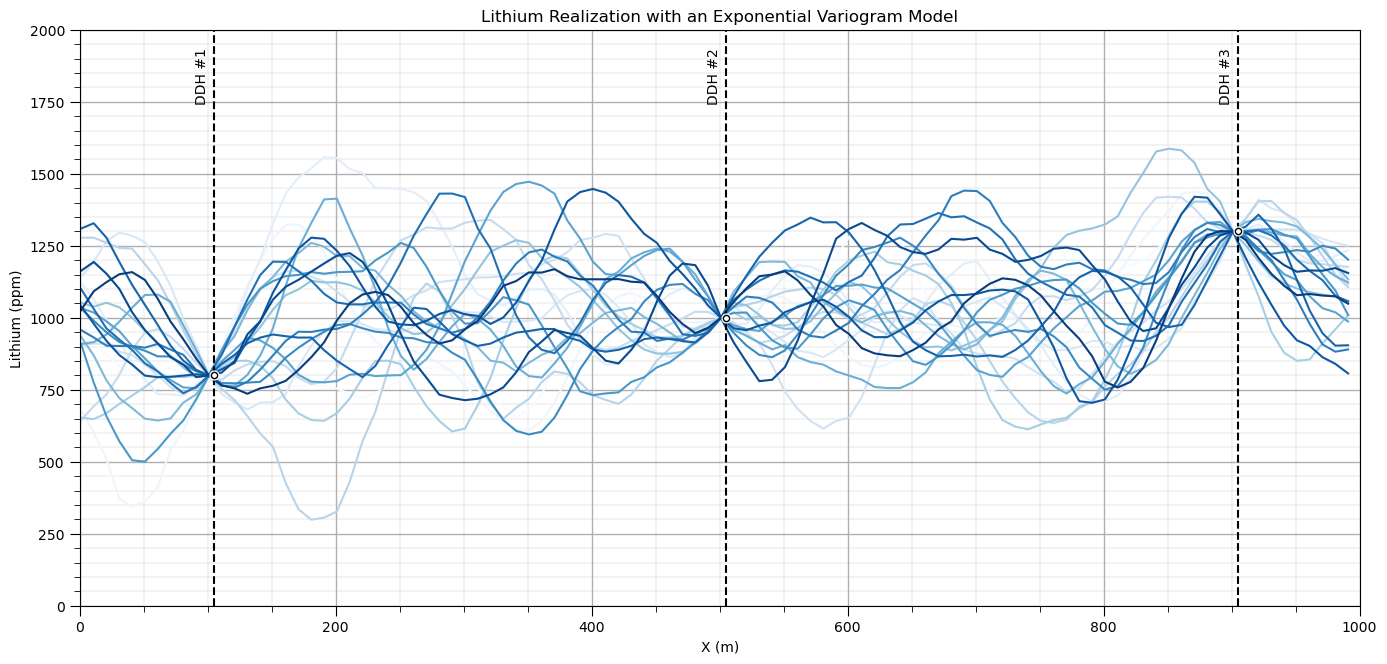

In [17]:
nreal = 20; vrange = 100                                      # number of realizations and variogram range

vario = GSLIB.make_variogram(nug=0.001,nst=1,it1=3,cc1=0.999,azi1=90.0,hmaj1=100,hmin1=5)

with io.capture_output() as captured:                         # simulation while muting output
    sim_Gaussian = geostats.sgsim(df,'X','Y','Lithium',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,
        dftrans=0,tcol=0,twtcol=0,zmin=0.0,zmax=2000.0,ltail=1,ltpar=0.0,utail=1,utpar=2000,nsim=nreal,
        nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73074,ndmin=ndmin,ndmax=ndmax,nodmax=10,
        mults=0,nmult=2,noct=-1,ktype=0,colocorr=0.0,sec_map=0,vario=vario).reshape((20,100))

plt.subplot(111)                                              # plot variograms
for i in range(0, nreal):    
    plt.plot(np.arange(1,(nx*xsiz),xsiz),sim_Gaussian[i],color=plt.cm.Blues(i/nreal),label='Real ' + str(i+1),zorder=1)
        
for idata in range(0,3):                                      # plot data
    plt.plot([df.loc[idata,'X'],df.loc[idata,'X']],[lithmin,lithmax],color='black',ls='--')
    plt.scatter(df.loc[idata,'X'],df.loc[idata,'Lithium'],s=20,color='white',edgecolor='black',zorder=10)
    plt.scatter(df.loc[idata,'X'],df.loc[idata,'Lithium'],s=40,color='white',edgecolor='white',zorder=9)
    plt.annotate(r'DDH #' + str(idata+1),(df.loc[idata,'X']-15,1750),rotation = 90);
    
plt.ylim([lithmin,lithmax]); plt.xlim([xmin,xmax]); add_grid()
plt.xlabel('X (m)'); plt.ylabel('Lithium (ppm)'); plt.title('Lithium Realization with an Exponential Variogram Model')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()

#### Vary the Variogram Model Type

Let's compare the variogram models by plotting them all together.

* spherical
* exponential
* Gaussian

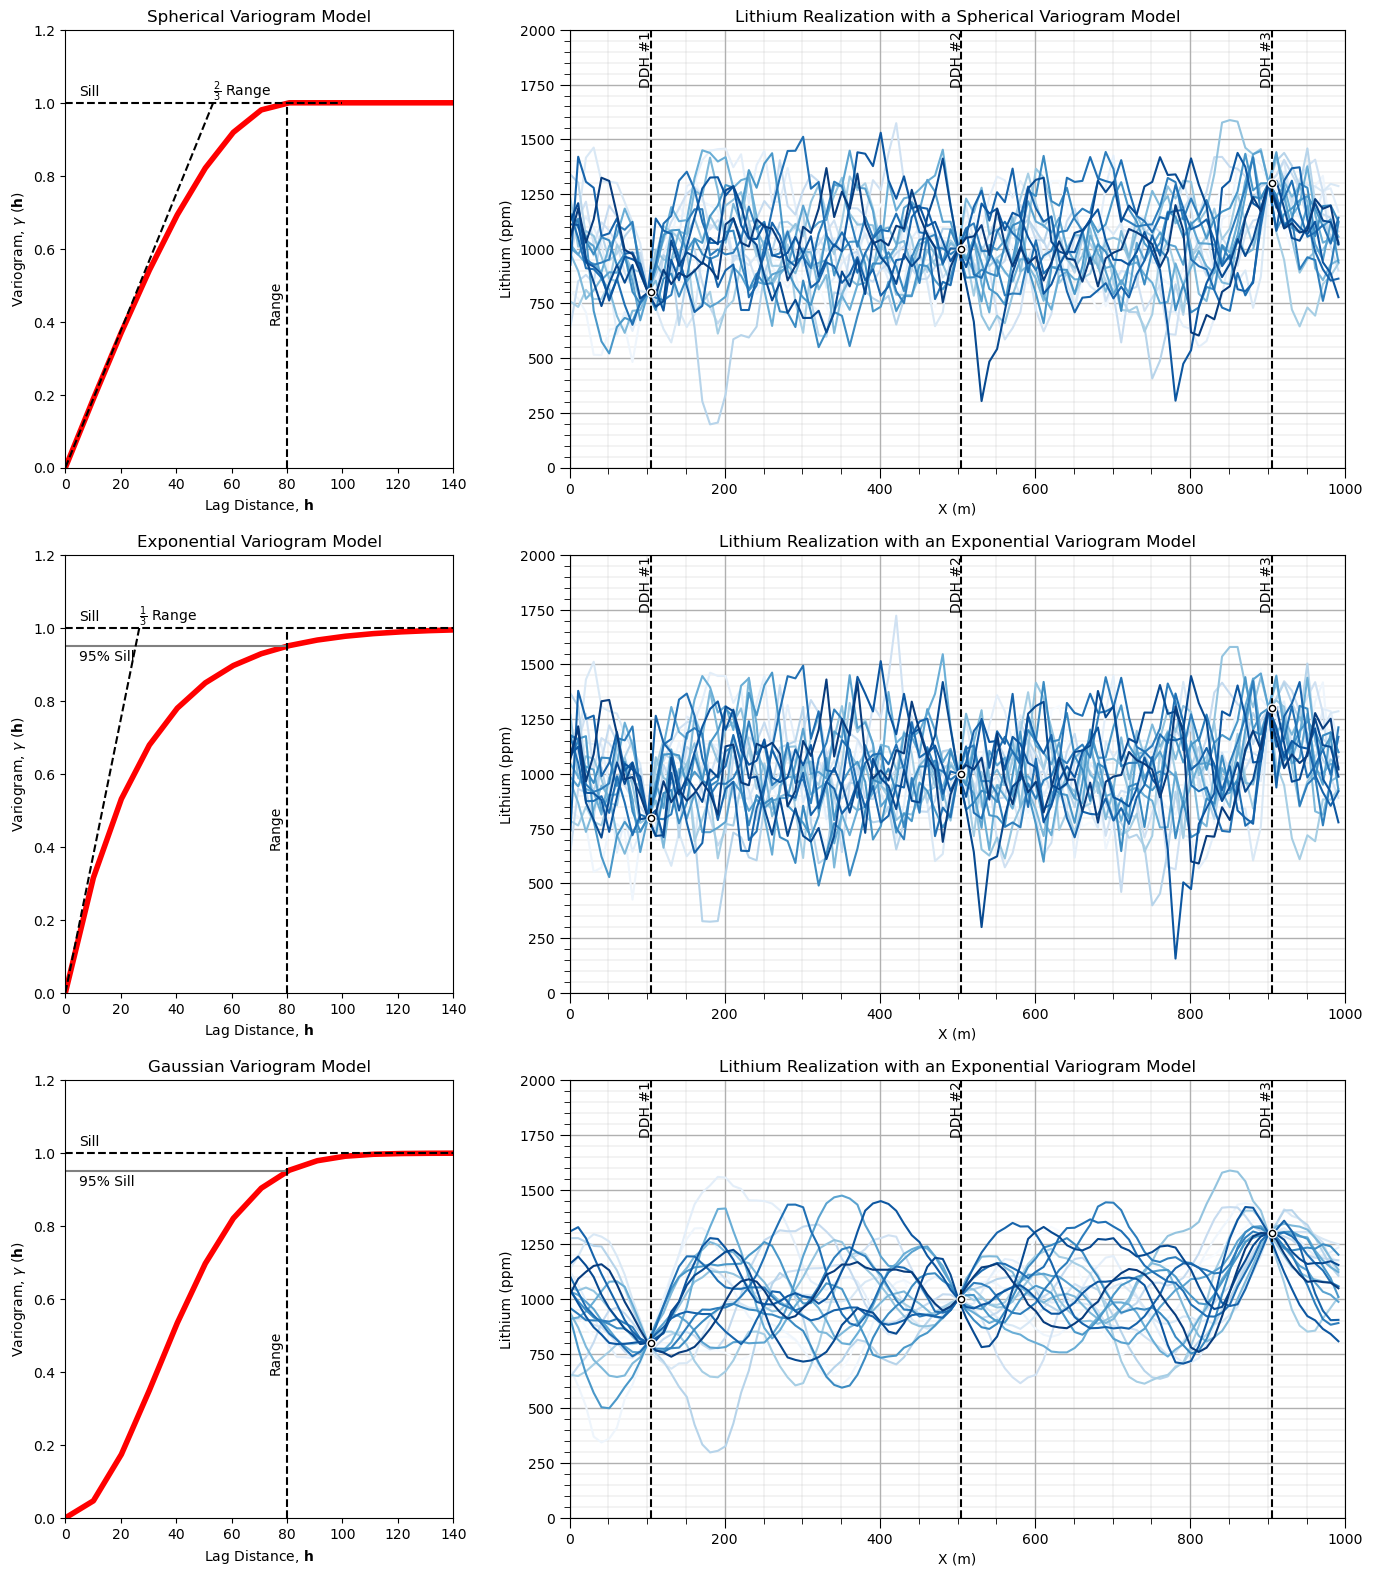

In [19]:
nreal = 20; vrange = 80                                       # number of realizations and variogram range
h = np.linspace(0,1000,100)

fig = plt.figure()
grid_spec = gridspec.GridSpec(ncols = 2,nrows=3,width_ratios=[1, 2])

ax0 = fig.add_subplot(grid_spec[0])
gamma_sph = 1.0*(1.5*h/vrange) - 0.5*np.power(h/vrange,3)
gamma_sph[h > vrange] = 1.0

plot = ax0.plot(h,gamma_sph,color='red',lw=4)
plt.plot([0,100],[1.0,1.0],color='black',ls='--'); plt.annotate('Sill',[5,1.02])
plt.plot([0,vrange*2/3],[0,1.0],color='black',ls='--'); plt.annotate(r'$\frac{2}{3}$ Range',[vrange*2/3,1.02])
plt.plot([vrange,vrange],[0.0,1.0],color='black',ls='--'); plt.annotate('Range',[vrange-6.5,0.4],rotation=90.0)
plt.xlim([0,140]); plt.ylim([0,1.2])
plt.xlabel(r'Lag Distance, $\bf{h}$'); plt.ylabel(r'Variogram, $\gamma$ ($\bf{h}$)')
plt.title('Spherical Variogram Model')

ax1 = fig.add_subplot(grid_spec[1])
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=90.0,hmaj1=vrange,hmin1=5)

with io.capture_output() as captured:                         # simulation while muting output
    sim_spherical = geostats.sgsim(df,'X','Y','Lithium',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,
        dftrans=0,tcol=0,twtcol=0,zmin=0.0,zmax=2000.0,ltail=1,ltpar=0.0,utail=1,utpar=2000,nsim=nreal,
        nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73074,ndmin=ndmin,ndmax=ndmax,nodmax=10,
        mults=0,nmult=2,noct=-1,ktype=0,colocorr=0.0,sec_map=0,vario=vario).reshape((20,100))

for i in range(0, nreal):    
    plt.plot(np.arange(1,(nx*xsiz),xsiz),sim_spherical[i],color=plt.cm.Blues(i/nreal),label='Real ' + str(i+1),zorder=1)
        
for idata in range(0,3):                                      # plot data
    plt.plot([df.loc[idata,'X'],df.loc[idata,'X']],[lithmin,lithmax],color='black',ls='--')
    plt.scatter(df.loc[idata,'X'],df.loc[idata,'Lithium'],s=20,color='white',edgecolor='black',zorder=10)
    plt.scatter(df.loc[idata,'X'],df.loc[idata,'Lithium'],s=40,color='white',edgecolor='white',zorder=9)
    plt.annotate(r'DDH #' + str(idata+1),(df.loc[idata,'X']-15,1750),rotation = 90);
    
plt.ylim([lithmin,lithmax]); plt.xlim([xmin,xmax]); add_grid()
plt.xlabel('X (m)'); plt.ylabel('Lithium (ppm)'); plt.title('Lithium Realization with a Spherical Variogram Model')

ax2 = fig.add_subplot(grid_spec[2])
gamma_exp = 1.0*(1.0-np.exp(-3*(h/vrange)))

plot = ax2.plot(h,gamma_exp,color='red',lw=4)
plt.plot([0,150],[1.0,1.0],color='black',ls='--'); plt.annotate('Sill',[5,1.02])
plt.plot([0,vrange],[0.95,0.95],color='grey',ls='-'); plt.annotate('95% Sill',[5,0.91])
plt.plot([vrange,vrange],[0.0,1.0],color='black',ls='--'); plt.annotate('Range',[vrange-6.5,0.4],rotation=90.0)
plt.plot([0,vrange*1/3],[0,1.0],color='black',ls='--'); plt.annotate(r'$\frac{1}{3}$ Range',[vrange*1/3,1.02])
plt.xlim([0,140]); plt.ylim([0,1.2])
plt.xlabel(r'Lag Distance, $\bf{h}$'); plt.ylabel(r'Variogram, $\gamma$ ($\bf{h}$)')
plt.title('Exponential Variogram Model')

ax3 = fig.add_subplot(grid_spec[3])
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=2,cc1=1.0,azi1=90.0,hmaj1=vrange,hmin1=5)

with io.capture_output() as captured:                         # simulation while muting output
    sim_exponential = geostats.sgsim(df,'X','Y','Lithium',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,
        dftrans=0,tcol=0,twtcol=0,zmin=0.0,zmax=2000.0,ltail=1,ltpar=0.0,utail=1,utpar=2000,nsim=nreal,
        nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73074,ndmin=ndmin,ndmax=ndmax,nodmax=10,
        mults=0,nmult=2,noct=-1,ktype=0,colocorr=0.0,sec_map=0,vario=vario).reshape((20,100))

for i in range(0, nreal):    
    plt.plot(np.arange(1,(nx*xsiz),xsiz),sim_exponential[i],color=plt.cm.Blues(i/nreal),label='Real ' + str(i+1),zorder=1)
        
for idata in range(0,3):                                      # plot data
    plt.plot([df.loc[idata,'X'],df.loc[idata,'X']],[lithmin,lithmax],color='black',ls='--')
    plt.scatter(df.loc[idata,'X'],df.loc[idata,'Lithium'],s=20,color='white',edgecolor='black',zorder=10)
    plt.scatter(df.loc[idata,'X'],df.loc[idata,'Lithium'],s=40,color='white',edgecolor='white',zorder=9)
    plt.annotate(r'DDH #' + str(idata+1),(df.loc[idata,'X']-15,1750),rotation = 90);
    
plt.ylim([lithmin,lithmax]); plt.xlim([xmin,xmax]); add_grid()
plt.xlabel('X (m)'); plt.ylabel('Lithium (ppm)'); plt.title('Lithium Realization with an Exponential Variogram Model')

ax4 = fig.add_subplot(grid_spec[4])
gamma_gaus = 1.0*(1.0-np.exp(-3*np.power(h/vrange,2)))

plot = ax4.plot(h,gamma_gaus,color='red',lw=4)
plt.plot([0,150],[1.0,1.0],color='black',ls='--'); plt.annotate('Sill',[5,1.02])
plt.plot([0,vrange],[0.95,0.95],color='grey',ls='-'); plt.annotate('95% Sill',[5,0.91])
plt.plot([vrange,vrange],[0.0,1.0],color='black',ls='--'); plt.annotate('Range',[vrange-6.5,0.4],rotation=90.0)
plt.xlim([0,140]); plt.ylim([0,1.2])
plt.xlabel(r'Lag Distance, $\bf{h}$'); plt.ylabel(r'Variogram, $\gamma$ ($\bf{h}$)')
plt.title('Gaussian Variogram Model')

ax5 = fig.add_subplot(grid_spec[5])
vario = GSLIB.make_variogram(nug=0.001,nst=1,it1=3,cc1=0.999,azi1=90.0,hmaj1=100,hmin1=5)

with io.capture_output() as captured:                         # simulation while muting output
    sim_Gaussian = geostats.sgsim(df,'X','Y','Lithium',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,
        dftrans=0,tcol=0,twtcol=0,zmin=0.0,zmax=2000.0,ltail=1,ltpar=0.0,utail=1,utpar=2000,nsim=nreal,
        nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73074,ndmin=ndmin,ndmax=ndmax,nodmax=10,
        mults=0,nmult=2,noct=-1,ktype=0,colocorr=0.0,sec_map=0,vario=vario).reshape((20,100))

for i in range(0, nreal):    
    plt.plot(np.arange(1,(nx*xsiz),xsiz),sim_Gaussian[i],color=plt.cm.Blues(i/nreal),label='Real ' + str(i+1),zorder=1)
        
for idata in range(0,3):                                      # plot data
    plt.plot([df.loc[idata,'X'],df.loc[idata,'X']],[lithmin,lithmax],color='black',ls='--')
    plt.scatter(df.loc[idata,'X'],df.loc[idata,'Lithium'],s=20,color='white',edgecolor='black',zorder=10)
    plt.scatter(df.loc[idata,'X'],df.loc[idata,'Lithium'],s=40,color='white',edgecolor='white',zorder=9)
    plt.annotate(r'DDH #' + str(idata+1),(df.loc[idata,'X']-15,1750),rotation = 90);
    
plt.ylim([lithmin,lithmax]); plt.xlim([xmin,xmax]); add_grid()
plt.xlabel('X (m)'); plt.ylabel('Lithium (ppm)'); plt.title('Lithium Realization with an Exponential Variogram Model')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=3.1, wspace=0.2, hspace=0.2); plt.show()

There is a clear difference in short scale continuity, with increasing short scale spatial continuity from exponential to spherical to Gaussian. But the long range spatial continuity does not change significantly.

#### Vary the Nugget Effect

Now's let's use the same spherical variogram model with constant range and just vary the relative nugget effect:
* 0% relative nugget effect
* 50% relative nugget effect
* 90% relative nugget effect

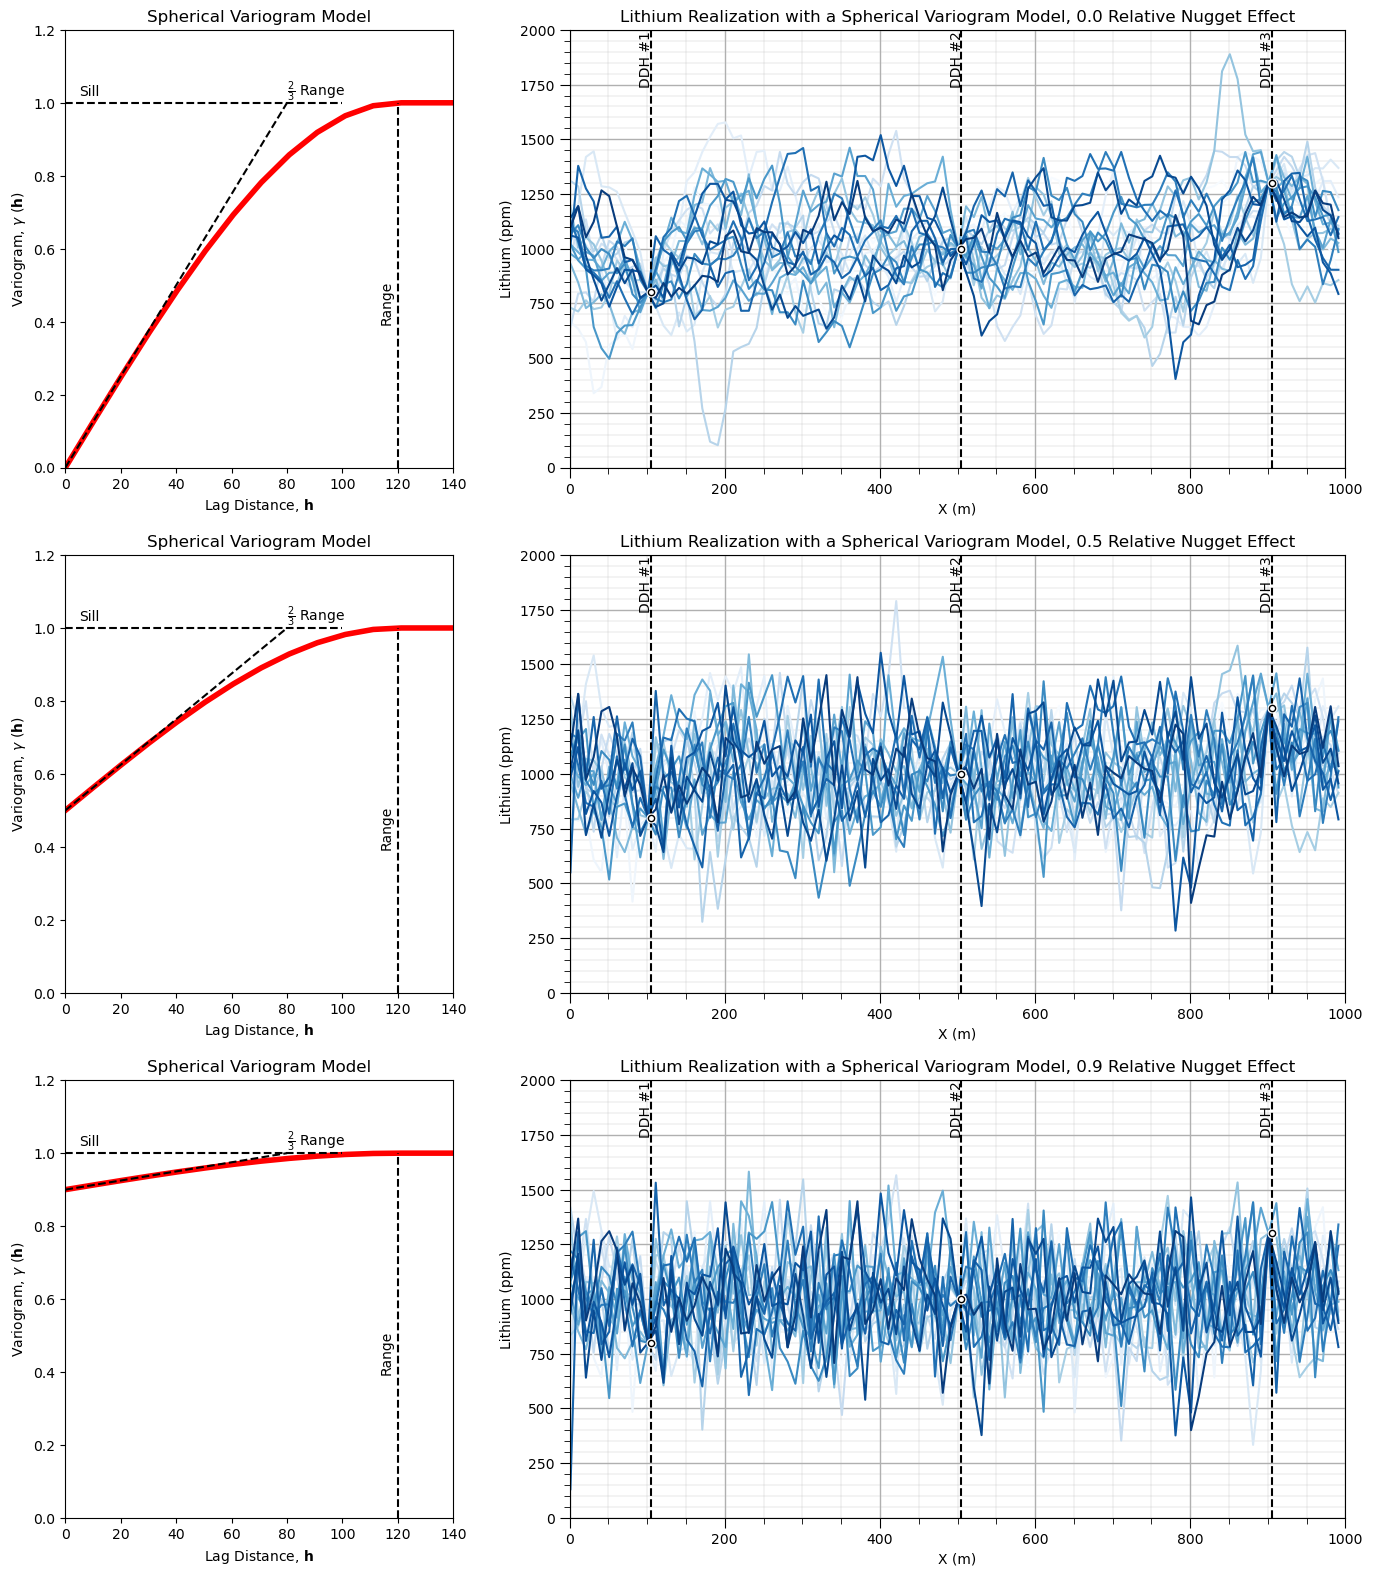

In [21]:
nreal = 20; vrange = 120                                      # number of realizations and variogram range
nugget = [0.0,0.5,0.9]                                        # relative nugget effects

fig = plt.figure()
grid_spec = gridspec.GridSpec(ncols = 2,nrows=3,width_ratios=[1, 2])

for inug in range(0,len(nugget)):

    ax0 = fig.add_subplot(grid_spec[inug*2])
    gamma_sph = (1.0-nugget[inug])*((1.5*h/vrange) - 0.5*np.power(h/vrange,3))+nugget[inug]
    gamma_sph[h > vrange] = 1.0
    
    plot = ax0.plot(h,gamma_sph,color='red',lw=4)             # plot the variogram model
    plt.plot([0,100],[1.0,1.0],color='black',ls='--'); plt.annotate('Sill',[5,1.02])
    plt.plot([0,vrange*2/3],[nugget[inug],1.0],color='black',ls='--'); plt.annotate(r'$\frac{2}{3}$ Range',[vrange*2/3,1.02])
    plt.plot([vrange,vrange],[0.0,1.0],color='black',ls='--'); plt.annotate('Range',[vrange-6.5,0.4],rotation=90.0)
    plt.xlim([0,140]); plt.ylim([0,1.2])
    plt.xlabel(r'Lag Distance, $\bf{h}$'); plt.ylabel(r'Variogram, $\gamma$ ($\bf{h}$)')
    plt.title('Spherical Variogram Model')
    
    ax1 = fig.add_subplot(grid_spec[inug*2+1])
    vario = GSLIB.make_variogram(nug=nugget[inug],nst=1,it1=1,cc1=1.0-nugget[inug],azi1=90.0,hmaj1=vrange,hmin1=5)

    with io.capture_output() as captured:                     # calculate the simulated realizations
        sim_spherical = geostats.sgsim(df,'X','Y','Lithium',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,
            dftrans=0,tcol=0,twtcol=0,zmin=0.0,zmax=2000.0,ltail=1,ltpar=0.0,utail=1,utpar=2000,nsim=nreal,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73074,ndmin=ndmin,ndmax=ndmax,nodmax=10,
            mults=0,nmult=2,noct=-1,ktype=0,colocorr=0.0,sec_map=0,vario=vario).reshape((20,100))
    
    for i in range(0, nreal):    
        plt.plot(np.arange(1,(nx*xsiz),xsiz),sim_spherical[i],color=plt.cm.Blues(i/nreal),label='Real ' + str(i+1),zorder=1)

    for idata in range(0,3):                                  # plot the simulated realizations
        plt.plot([df.loc[idata,'X'],df.loc[idata,'X']],[lithmin,lithmax],color='black',ls='--')
        plt.scatter(df.loc[idata,'X'],df.loc[idata,'Lithium'],s=20,color='white',edgecolor='black',zorder=10)
        plt.scatter(df.loc[idata,'X'],df.loc[idata,'Lithium'],s=40,color='white',edgecolor='white',zorder=9)
        plt.annotate(r'DDH #' + str(idata+1),(df.loc[idata,'X']-15,1750),rotation = 90);
        
    plt.ylim([lithmin,lithmax]); plt.xlim([xmin,xmax]); add_grid()
    plt.xlabel('X (m)'); plt.ylabel('Lithium (ppm)'); 
    plt.title('Lithium Realization with a Spherical Variogram Model, ' + str(nugget[inug]) + ' Relative Nugget Effect')
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=3.1, wspace=0.2, hspace=0.2); plt.show()

There is a clear difference in short scale continuity, with decreasing short scale spatial continuity with increase in relative nugget effect.

#### Comments

This was a basic demonstration of variogram calculation with GeostatsPy. Much more can be done, I have other demonstrations for modeling workflows with GeostatsPy in the GitHub repository [GeostatsPy_Demos](https://github.com/GeostatsGuy/GeostatsPy_Demos/tree/main).

I hope this is helpful,

*Michael*

#### About the Author

<figure style="text-align: center;">
  <img src="_static/intro/michael_pyrcz_officeshot_jacket.jpg" style="display: block; margin: 0 auto; width: 70%;">
  <figcaption style="text-align: center;"> Professor Michael Pyrcz in his office on the 40 acres, campus of The University of Texas at Austin.
</figcaption>
</figure>

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences. 

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)